In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

import warnings

from collections import defaultdict

# Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Modelling
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, GridSearchCV

## Linear Model
from sklearn.linear_model import LogisticRegression

## Bayesian Modelling
from sklearn.naive_bayes import ComplementNB, MultinomialNB

## Tree-based Modelling
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

## Nearest-Neighbour Modelling
from sklearn.neighbors import KNeighborsClassifier

### Support Vector Machines
from sklearn.svm import SVC

# Metrics
from sklearn.metrics import f1_score, classification_report, confusion_matrix, recall_score

from scipy.stats import uniform


warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("./data/clean_health - clean_health.csv")
df.head()

,papaId,createdAt,eventType,DeviceID,MessageID,Payload,path,hops,duckType,corrupted_device,corrupted_message,charging,counter,full,volts,board_temp,packet_loss,is_lost
0,OWL_HQ,2022-03-14 21:00:04,health,HEALTHDK,I9EG,Counter:3 Charging:0 Full:0 Volts:4098.60 Temp...,NaN,1,2,0,0,0,3,0,4098.6,44.0,NaN,0
1,OWL_HQ,2022-03-14 21:00:40,health,HEALTHDK,O008,Counter:6 Charging:0 Full:0 Volts:4136.00 Temp...,NaN,1,2,0,0,0,6,0,4136.0,44.8,3.0,1
2,OWL_HQ,2022-03-14 21:00:56,health,HEALTHDK,TVIM,Counter:7 Charging:0 Full:0 Volts:4136.00 Temp...,NaN,1,2,0,0,0,7,0,4136.0,44.8,1.0,0
3,OWL_HQ,2022-03-14 21:01:52,health,HEALTHDK,YXEC,Counter:12 Charging:0 Full:0 Volts:4137.10 Tem...,NaN,1,2,0,0,0,12,0,4137.1,45.0,5.0,1
4,OWL_HQ,2022-03-14 21:02:29,health,HEALTHDK,329F,Counter:15 Charging:0 Full:0 Volts:4137.10 Tem...,NaN,1,2,0,0,0,15,0,4137.1,44.8,3.0,1


In [3]:
print(f"Number of records in the data: {df.shape[0]}")
print(f"Number of attributes in the data: {df.shape[1]}")

Number of records in the data: 44202
Number of attributes in the data: 18


# Exploratory Data Analysis

## 1. Percentage of Missing Data

In [4]:
pd.DataFrame((df.isna().sum()/df.isna().count()) * 100, columns=['percent_miss']).sort_values(by='percent_miss', ascending=False)

,percent_miss
path,100.000000
packet_loss,0.002262
papaId,0.000000
corrupted_message,0.000000
board_temp,0.000000
volts,0.000000
full,0.000000
counter,0.000000
charging,0.000000
corrupted_device,0.000000


## 2. Number of unique eventTypes

In [5]:
print(f"Number of unique eventTypes: {df['eventType'].nunique()}")
print(f"Unique EventTypes: {df['eventType'].unique().tolist()}")

Number of unique eventTypes: 1
Unique EventTypes: ['health']


## 3. Number of unique DeviceID

In [6]:
print(f"Number of unique DeviceIDs: {df['DeviceID'].nunique()}")
print(f"Unique DeviceIDs: {df['DeviceID'].unique().tolist()}")

Number of unique DeviceIDs: 1
Unique DeviceIDs: ['HEALTHDK']


## 4. Distribution of hops

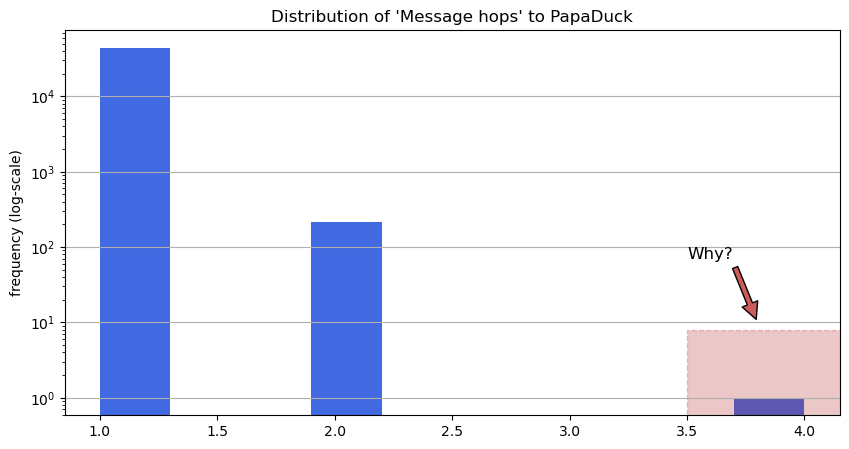

In [7]:
ax = df['hops'].plot(kind="hist", title="Distribution of 'Message hops' to PapaDuck", 
                                    color="royalblue", grid=True, figsize=(10, 5))

rect = plt.Rectangle((3.5, 0), 4, 8, alpha=.25, color="firebrick", linestyle="--")
ax.grid(visible=False, which='major', axis='x')
ax.set_yscale('log')
ax.set_ylabel('frequency (log-scale)')
plt.gca().add_patch(rect)
ax.annotate('Why?', (3.8, 10), xytext=(3.5, 70), arrowprops=dict(facecolor="indianred", shrink=0.05), fontsize=12)
plt.show()

## 5. Number of unique duckType

In [8]:
print(f"Number of unique duckType: {df['duckType'].nunique()}")
print(f"Unique duckTypes: {df['duckType'].unique().tolist()}")

Number of unique duckType: 1
Unique duckTypes: [2]


## 6. Distribution of corrupted-device

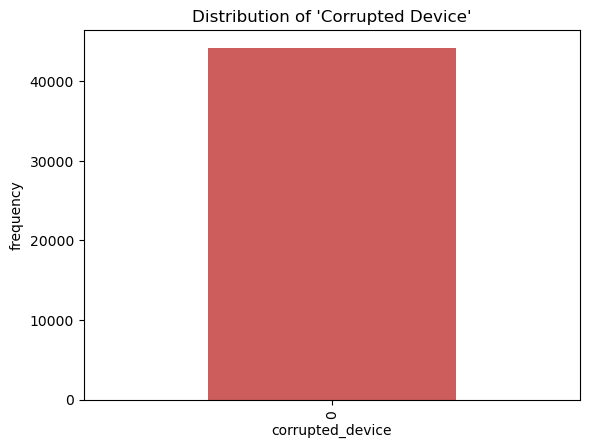

In [9]:
df.groupby('corrupted_device').size().plot(kind="bar", title="Distribution of 'Corrupted Device'", color="indianred")
plt.ylabel("frequency")
plt.show()

## 7. Distribution of corrupted-message

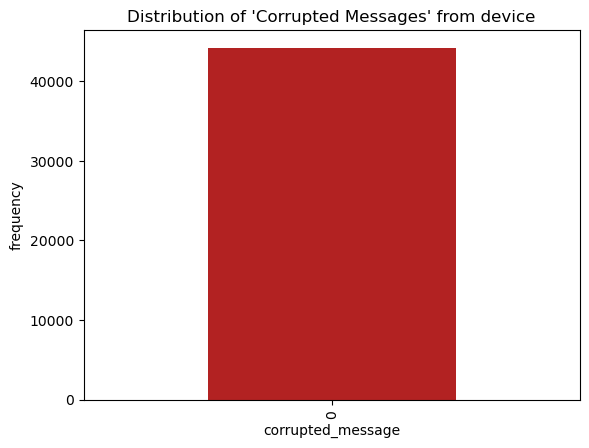

In [10]:
df.groupby('corrupted_message').size().plot(kind="bar", title="Distribution of 'Corrupted Messages' from device", color="firebrick")
plt.ylabel('frequency')
plt.show()

## 8. Distribution of charging

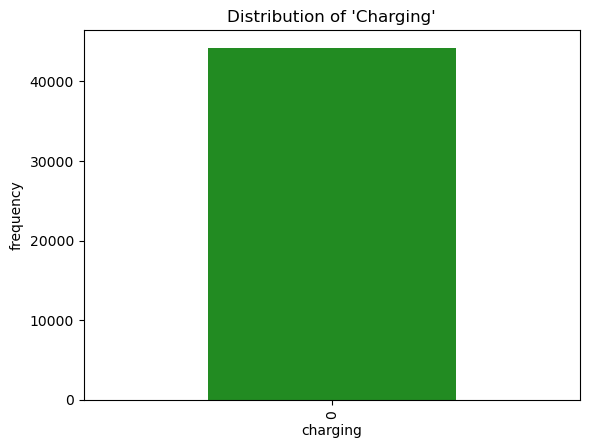

In [11]:
df.groupby('charging').size().plot(kind="bar", title="Distribution of 'Charging'", color="forestgreen")
plt.ylabel("frequency")
plt.show()

## 9. Distribution of counter

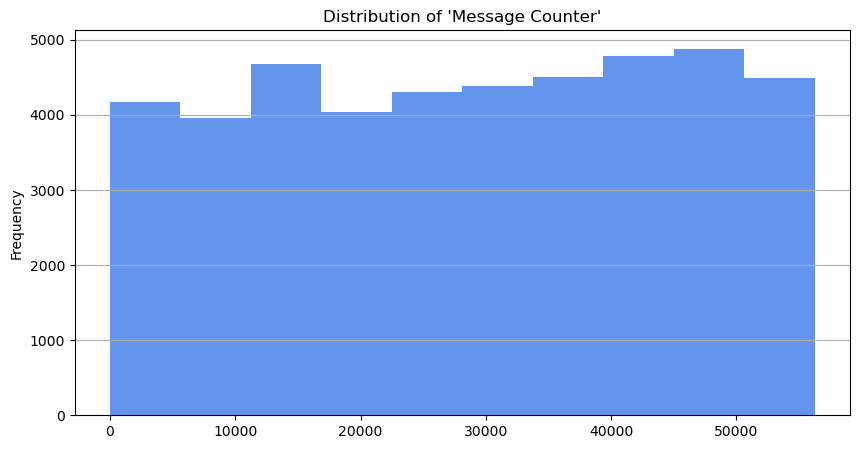

In [12]:
ax = df['counter'].plot(kind="hist", title="Distribution of 'Message Counter'",
                   figsize=(10, 5), color="cornflowerblue", grid=True)

ax.grid(visible=False, which='major', axis="x")
plt.show()

## 10. Distribution of fully-charged devices

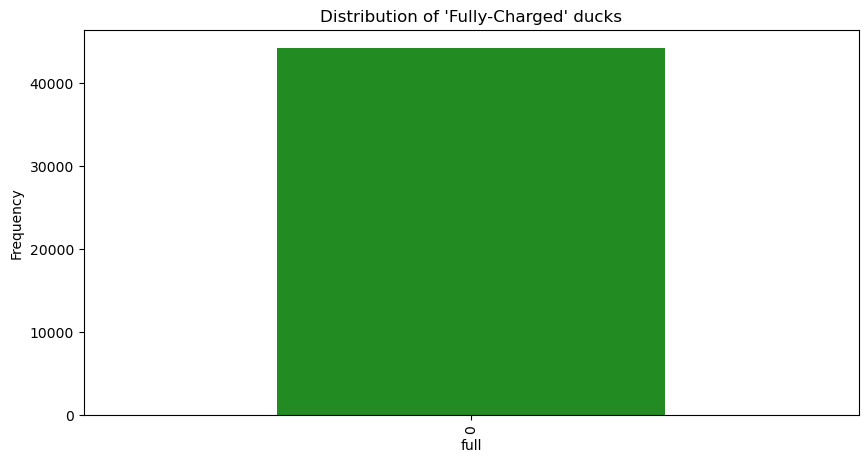

In [13]:
df.groupby('full').size().plot(kind="bar", color="forestgreen", figsize=(10, 5),
                              title="Distribution of 'Fully-Charged' ducks")
plt.ylabel("Frequency")
plt.show()

## 11. Distribution of volts

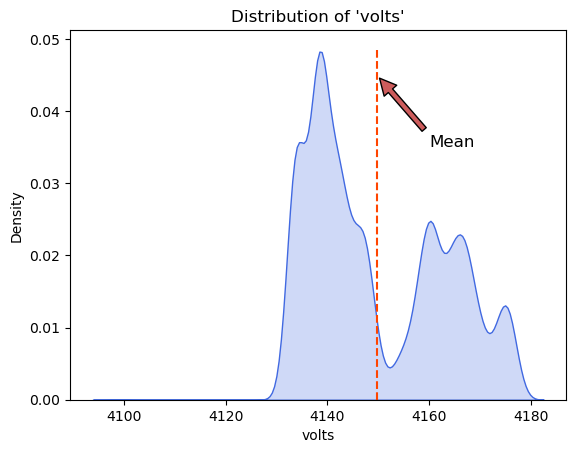

In [14]:
ax = sns.kdeplot(x="volts", data=df, fill=True, color="royalblue")
ax.set_title("Distribution of 'volts'")
ax.vlines(df['volts'].mean(), ymin=0, ymax=0.0488, linestyle="--", color="orangered")
ax.annotate('Mean', (df['volts'].mean(), 0.045), xytext=(4160, 0.035), arrowprops=dict(facecolor="indianred", shrink=0.05), fontsize=12)
plt.show()

## 12. Distribution of Board-Temperature

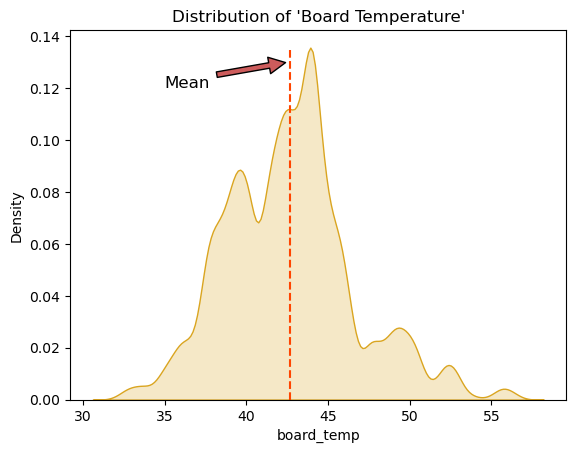

In [15]:
ax = sns.kdeplot(x="board_temp", data=df, fill=True, color="goldenrod")
ax.set_title("Distribution of 'Board Temperature'")
ax.vlines(df['board_temp'].mean(), ymin=0, ymax=0.1355, linestyle="--", color="orangered")
ax.annotate('Mean', (df['board_temp'].mean(), 0.13), xytext=(35, 0.12), arrowprops=dict(facecolor="indianred", shrink=0.05), fontsize=12)
plt.show()

## 13. Distribution of Packet-Loss

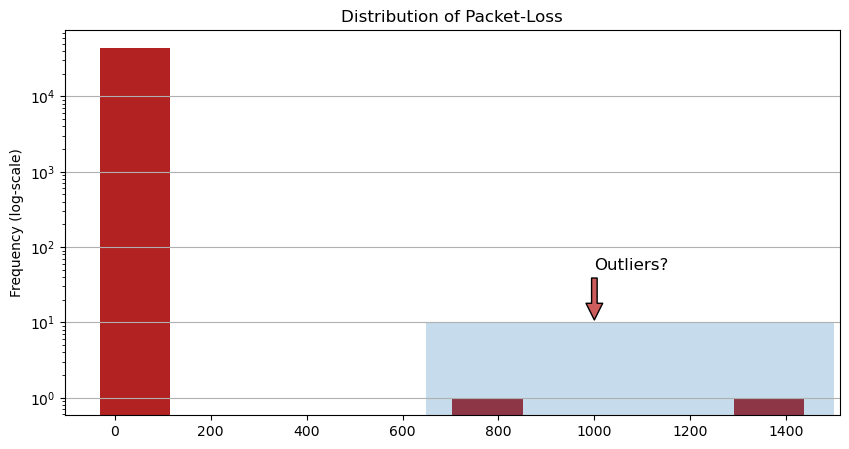

In [16]:
ax = df['packet_loss'].plot(kind="hist", color="firebrick", 
                            figsize=(10, 5), title="Distribution of Packet-Loss", grid=True)
ax.grid(visible=False, which="major", axis="x")
ax.set_yscale('log')
ax.set_ylabel('Frequency (log-scale)')
rect = plt.Rectangle((650, 0), 850, 10, linestyle="--", alpha=0.25)
plt.gca().add_patch(rect)
ax.annotate("Outliers?", (1000, 10), xytext=(1000, 50), arrowprops=dict(facecolor="indianred", shrink=0.05), fontsize=12)
plt.show()

## 14. Distribution of Target Variable

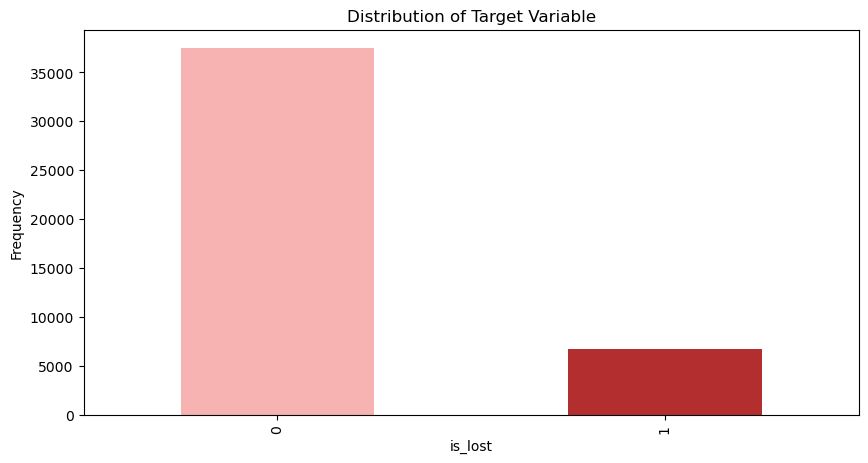

In [17]:
df.groupby('is_lost').size().plot(kind="bar", color=("#f7b2b2", "#b32e2e"), 
                                  title="Distribution of Target Variable", figsize=(10, 5))
plt.ylabel("Frequency")
plt.show()

# Observations from EDA

1. There is only **one** instance of `hops` that is $>3$.
2. KPIs such as `ducktype`, `corrupted_device`, `corrupted_message`, `charging` & `full` all have $0$ variation and therefore can be disregarded during data-modelling.
3. The distribution of `board_temp` almost follows a *Gaussian Distribution*.

# Data-Modeling

In [18]:
kpis = ['hops', 'counter', 'volts', 'board_temp', 'is_lost']
df_new = df[kpis]
df_new.head()

,hops,counter,volts,board_temp,is_lost
0,1,3,4098.6,44.0,0
1,1,6,4136.0,44.8,1
2,1,7,4136.0,44.8,0
3,1,12,4137.1,45.0,1
4,1,15,4137.1,44.8,1


In [19]:
df_train, df_test = train_test_split(df_new, test_size=.15, random_state=42, shuffle=True, stratify=df_new['is_lost'])
print(f"Shape of the Training Dataset : {df_train.shape}")
print(f"Shape of the Test Dataset : {df_test.shape}")

Shape of the Training Dataset : (37571, 5)
Shape of the Test Dataset : (6631, 5)


In [20]:
X_train, y_train = df_train.drop('is_lost', axis=1).values, df_train['is_lost'].values
X_test, y_test = df_test.drop('is_lost', axis=1).values, df_test['is_lost'].values

In [21]:
def conf_visualizer(y_true:np.array, y_pred:np.array, labels:list) -> None:
    """ Function to pretty print the Confusion Matrix """
    
    grp = ["True Neg", "False Pos", "False Neg", "True Pos"]
    cf = confusion_matrix(y_true, y_pred, labels=labels)
    
    grp_cnts = [f"{cnt}" for cnt in cf.flatten()]
    grp_percent = [f"{val*100:.4f}%" for val in cf.flatten()/np.sum(cf)]
    
    
    annotations = [f"{x1}\n{x2}\n{x3}" for x1, x2, x3 in zip(grp, grp_cnts, grp_percent)]
    annotations = np.array(annotations).reshape(2, 2)
    
    plt.figure(figsize=(10, 5))
    plt.title("Confusion Matrix")
    sns.heatmap(cf, annot=annotations, cmap="Reds", fmt="")
    plt.ylabel("True Labels")
    plt.xlabel("Predictions")
    plt.show()

## 1. Logistic Regression - BaseLine

### 1.1 : Best Parameters Search

In [22]:
logreg_search = RandomizedSearchCV(LogisticRegression(max_iter=10000), 
                                  dict(C=uniform(loc=0, scale=1), tol=[1e-4, 1e-3, 1e-2], 
                                       penalty=['l1', 'l2']), n_iter=100, n_jobs=-1, 
                                   cv=StratifiedKFold(shuffle=True), scoring='recall', random_state=42)

scaler = StandardScaler()
logreg_search.fit(scaler.fit_transform(X_train), y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
                   estimator=LogisticRegression(max_iter=10000), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fa09d90dbd0>,
                                        'penalty': ['l1', 'l2'],
                                        'tol': [0.0001, 0.001, 0.01]},
                   random_state=42, scoring='recall')

In [23]:
logreg_search.best_params_

{'C': 0.05808361216819946, 'penalty': 'l2', 'tol': 0.0001}

### 1.2 : Training on Best Parameters

In [24]:
logreg = LogisticRegression(random_state=42, max_iter=10000, n_jobs=-1, **logreg_search.best_params_)
scaler = StandardScaler()
logreg.fit(scaler.fit_transform(X_train), y_train)

print(classification_report(y_test, logreg.predict(scaler.transform(X_test))))
print(f"F1-Score of the model : {f1_score(y_test, logreg.predict(scaler.transform(X_test)))}")
print(f"Recall Score of the model : {recall_score(y_test, logreg.predict(scaler.transform(X_test)))}")

              precision    recall  f1-score   support

           0       0.85      1.00      0.92      5625
           1       0.00      0.00      0.00      1006

    accuracy                           0.85      6631
   macro avg       0.42      0.50      0.46      6631
weighted avg       0.72      0.85      0.78      6631

F1-Score of the model : 0.0
Recall Score of the model : 0.0


### 1.3 : Confusion Matrix

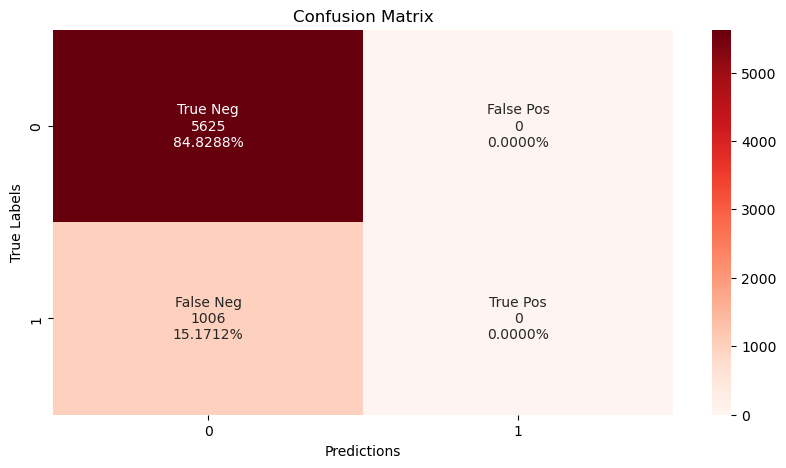

In [25]:
conf_visualizer(y_test, logreg.predict(scaler.transform(X_test)), logreg.classes_)

## 2. Naive Bayes

### 2.1 : Best Parameters Search

In [26]:
cbclf = ComplementNB()
cbclf_search = GridSearchCV(cbclf, dict(alpha=np.random.uniform(low=1e-1, high=10, size=100)), 
                            scoring='recall', cv=StratifiedKFold(shuffle=True), n_jobs=-1)
scaler = MinMaxScaler()
cbclf_search.fit(scaler.fit_transform(X_train), y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=ComplementNB(), n_jobs=-1,
             param_grid={'alpha': array([6.2482574 , 3.85801576, 2.38769713, 4.25149179, 4.96221024,
       4.38793768, 1.88345929, 2.32712054, 5.4647208 , 7.79638268,
       5.48342957, 2.74133062, 8.54356896, 7.24159443, 6.91015558,
       6.63841752, 6.42524038, 4.49385354, 2.01172339, 9.2893...
       9.85720226, 4.25432573, 4.25264121, 2.58246481, 3.25735099,
       6.98450597, 0.18888661, 5.40023125, 4.58300457, 1.96153393,
       0.60370852, 2.79179478, 6.89137053, 1.13256265, 1.61360303,
       2.66796822, 1.41792832, 9.45759146, 1.09910425, 9.5546927 ,
       6.78080832, 2.69252077, 9.8257031 , 4.33922503, 2.09231263,
       1.54493052, 8.27098008, 8.88054769, 1.92103765, 8.40438338,
       7.31570659, 0.78969628, 5.39671308, 9.94518721, 8.07782522])},
             scoring='recall')

In [27]:
cbclf_search.best_params_

{'alpha': 0.17199738516512203}

### 2.2 : Training on Best Parameters

In [28]:
cbclf = ComplementNB(**cbclf_search.best_params_)
scaler = MinMaxScaler()
cbclf.fit(scaler.fit_transform(X_train), y_train)

print(classification_report(y_test, cbclf.predict(scaler.transform(X_test))))
print(f"F1-Score of the model : {f1_score(y_test, cbclf.predict(scaler.transform(X_test)))}")
print(f"Recall Score of the model : {recall_score(y_test, cbclf.predict(scaler.transform(X_test)))}")

              precision    recall  f1-score   support

           0       0.84      0.48      0.61      5625
           1       0.14      0.48      0.22      1006

    accuracy                           0.48      6631
   macro avg       0.49      0.48      0.42      6631
weighted avg       0.73      0.48      0.55      6631

F1-Score of the model : 0.21979522184300343
Recall Score of the model : 0.4801192842942346


### 2.3 : Confusion Matrix

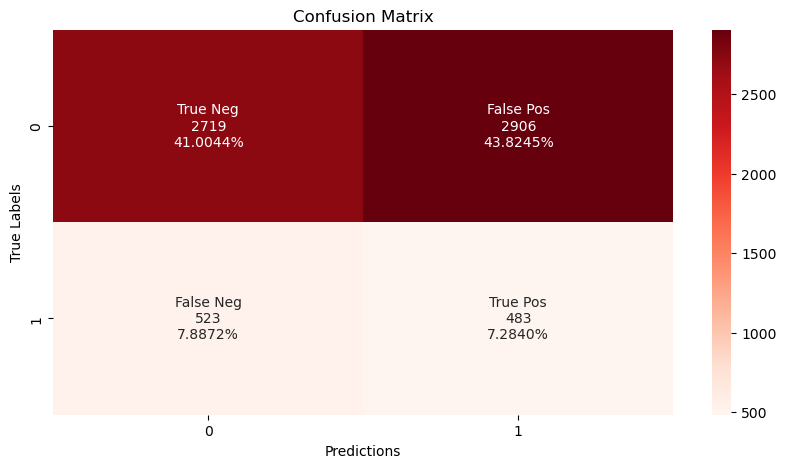

In [29]:
conf_visualizer(y_test, cbclf.predict(scaler.transform(X_test)), cbclf.classes_)

## 3. Decision Tree

### 3.1 : Best Parameter Search

In [30]:
dtree = DecisionTreeClassifier()
dtree_search = RandomizedSearchCV(dtree, 
                                  dict(ccp_alpha=np.random.uniform(low=0.0, high=1, size=100),
                                      class_weight=["balanced", "balanced_subsample"]),
                                 n_iter=1000,
                                 n_jobs=-1,
                                 cv=StratifiedKFold(shuffle=True), 
                                 scoring='recall')

dtree_search.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
                   estimator=DecisionTreeClassifier(), n_iter=1000, n_jobs=-1,
                   param_distributions={'ccp_alpha': array([0.51463433, 0.35393745, 0.64867074, 0.6848879 , 0.22432305,
       0.42429722, 0.65445053, 0.13842587, 0.9731123 , 0.83405921,
       0.79770676, 0.18614457, 0.65996216, 0.95373625, 0.96303269,
       0.9928000...
       0.71507322, 0.73074537, 0.54415116, 0.72131706, 0.62467308,
       0.58857929, 0.15123402, 0.66476328, 0.75210381, 0.84791024,
       0.08062242, 0.23973702, 0.48385157, 0.52609187, 0.43842635,
       0.78229005, 0.50874007, 0.73138658, 0.16317473, 0.64760607,
       0.18209411, 0.99999254, 0.94781329, 0.54534445, 0.58144042,
       0.16973132, 0.65675155, 0.13147504, 0.25105271, 0.81252275]),
                                        'class_weight': ['balanced',
                                                         'balanced_subsample']},
                   scoring='recall')

### 3.2 : Training on Best Parameters 

In [31]:
dtree_search.best_params_

{'class_weight': 'balanced', 'ccp_alpha': 0.0033917499125449835}

In [32]:
dtree = DecisionTreeClassifier(random_state=42, **dtree_search.best_params_)
dtree.fit(X_train, y_train)

print(classification_report(y_test, dtree.predict(X_test), labels=dtree.classes_))
print(f"F1-Score of the model : {f1_score(y_test, dtree.predict(X_test))}")
print(f"Recall Score of the model : {recall_score(y_test, dtree.predict(X_test))}")

              precision    recall  f1-score   support

           0       0.89      0.46      0.60      5625
           1       0.18      0.67      0.28      1006

    accuracy                           0.49      6631
   macro avg       0.53      0.56      0.44      6631
weighted avg       0.78      0.49      0.56      6631

F1-Score of the model : 0.2844425604069521
Recall Score of the model : 0.6669980119284294


### 3.3 : Confusion Matrix

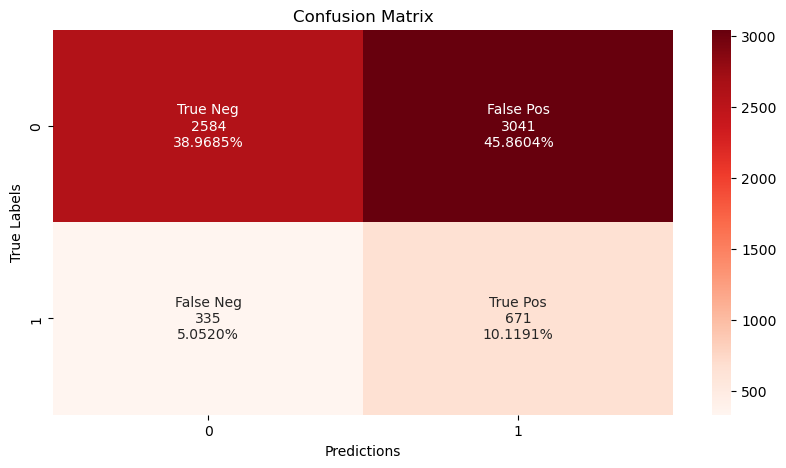

In [33]:
conf_visualizer(y_test, dtree.predict(X_test), dtree.classes_)

## 4. K-Nearest Neighbours

### 4.1 : Best Parameter Search

In [34]:
knn_search = GridSearchCV(KNeighborsClassifier(n_jobs=-1), dict(n_neighbors=[3, 5, 7, 9, 11, 21, 51, 101]), 
                          scoring='recall', cv=StratifiedKFold(shuffle=True), n_jobs=-1)

scaler = StandardScaler()
knn_search.fit(scaler.fit_transform(X_train), y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=KNeighborsClassifier(n_jobs=-1), n_jobs=-1,
             param_grid={'n_neighbors': [3, 5, 7, 9, 11, 21, 51, 101]},
             scoring='recall')

### 4.2 : Training on Best Parameters

In [35]:
knn_search.best_params_

{'n_neighbors': 3}

In [36]:
knn = KNeighborsClassifier(n_jobs=-1, **knn_search.best_params_)
knn.fit(scaler.transform(X_train), y_train)

print(classification_report(y_test, knn.predict(scaler.transform(X_test)), labels=knn.classes_))
print(f"F1-Score of the model : {f1_score(y_test, knn.predict(scaler.transform(X_test)))}")
print(f"Recall Score of the model : {recall_score(y_test, knn.predict(scaler.transform(X_test)))}")

              precision    recall  f1-score   support

           0       0.85      0.93      0.89      5625
           1       0.23      0.12      0.16      1006

    accuracy                           0.80      6631
   macro avg       0.54      0.52      0.52      6631
weighted avg       0.76      0.80      0.78      6631

F1-Score of the model : 0.1573472041612484
Recall Score of the model : 0.12027833001988071


### 4.3 : Confusion Matrix

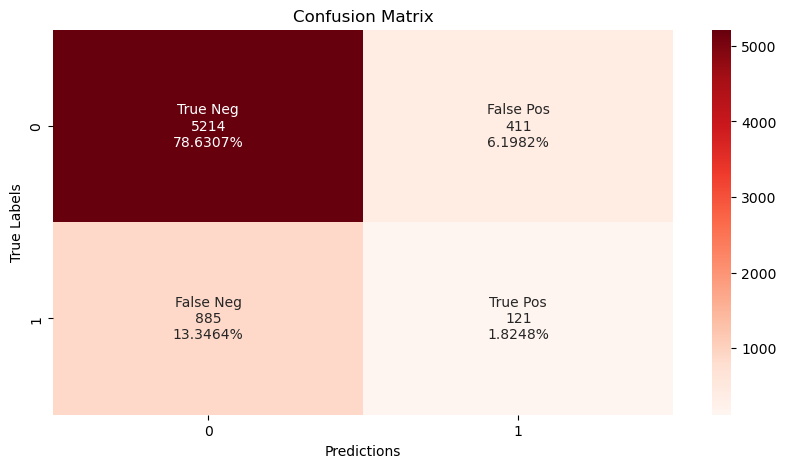

In [37]:
conf_visualizer(y_test, knn.predict(scaler.transform(X_test)), knn.classes_)

## 5. Support Vector Machine

### 5.1 : Best Parameter Search

In [38]:
svm_search = GridSearchCV(SVC(class_weight='balanced'), dict(C=np.random.uniform(low=0.01, high=10, size=100)), 
                          scoring='recall', cv=StratifiedKFold(shuffle=True), n_jobs=-1)

scaler = StandardScaler()
svm_search.fit(scaler.fit_transform(X_train), y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=SVC(class_weight='balanced'), n_jobs=-1,
             param_grid={'C': array([4.9025575 , 6.94020503, 8.73837839, 4.34243768, 7.43672601,
       6.29558685, 3.32282406, 2.21049794, 3.20185946, 4.19098396,
       2.83084955, 8.71211641, 5.44753525, 1.49735459, 5.25918524,
       0.55870709, 4.55621994, 6.86803116, 4.7628...
       4.50836381, 9.59101149, 6.88001246, 0.65712965, 9.47722936,
       3.87710866, 5.28259303, 1.53334966, 7.44420934, 5.65241483,
       5.97141134, 0.04646812, 6.88110639, 5.01235221, 4.31070552,
       2.57838692, 9.84748134, 3.07177474, 2.06441555, 6.75072444,
       5.34407389, 3.16884198, 7.79937216, 6.78065366, 1.87819434,
       0.82310298, 1.91582129, 4.43260099, 1.06372884, 6.58501459])},
             scoring='recall')

In [42]:
svm_search.best_params_, svm_search.best_score_

({'C': 9.526327284185086}, 0.626891548449702)

### 5.2 : Training on Best Parameters

In [43]:
svm = SVC(class_weight='balanced', **svm_search.best_params_)
svm.fit(scaler.transform(X_train), y_train)

print(classification_report(y_test, svm.predict(scaler.transform(X_test))))
print(f"F1-Score of the model : {f1_score(y_test, svm.predict(scaler.transform(X_test)))}")
print(f"Recall Score of the model : {recall_score(y_test, svm.predict(scaler.transform(X_test)))}")

              precision    recall  f1-score   support

           0       0.89      0.53      0.67      5625
           1       0.19      0.62      0.29      1006

    accuracy                           0.55      6631
   macro avg       0.54      0.58      0.48      6631
weighted avg       0.78      0.55      0.61      6631

F1-Score of the model : 0.294021101992966
Recall Score of the model : 0.6232604373757455


### 5.3 : Confusion Matrix

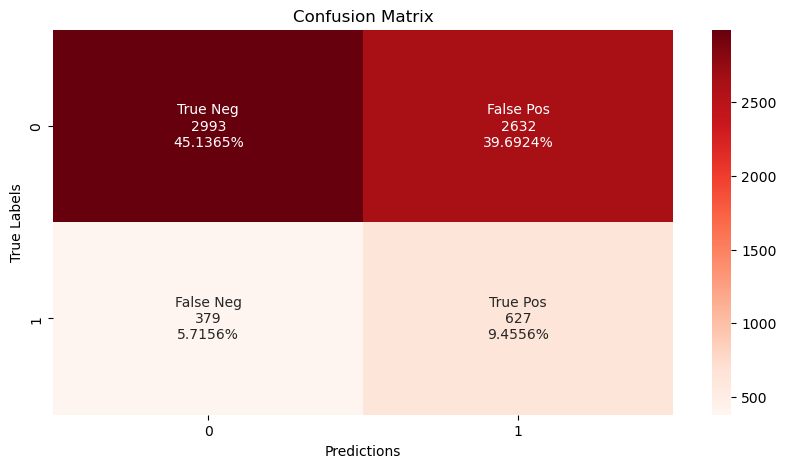

In [44]:
conf_visualizer(y_test, svm.predict(scaler.transform(X_test)), svm.classes_)